In [1]:
import sys
sys.path.append("../../../..")
%load_ext autoreload
%autoreload 1
import lightning.pytorch as pl
from lightning.pytorch.callbacks import DeviceStatsMonitor
from lightning.pytorch.tuner.tuning import Tuner
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from ntupleReaders.clue_ntuple_reader import ClueNtupleReader

from ml.dynamic_reduction_network import DynamicReductionNetwork
%aimport ml.regression.drn.modules
%aimport ml.regression.drn.plot
%aimport ml.regression.drn.dataset_making
from ml.regression.drn.modules import *
from ml.regression.drn.dataset_making import *
%aimport ml.regression.drn.callbacks
from ml.regression.drn.callbacks import SigmaOverECallback, SigmaOverEPlotter

%matplotlib inline

2023-06-15 15:33:33.574774: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-15 15:33:33.690474: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/grid_mnt/vol_home/llr/cms/cuisset/mambaforge/envs/clustering-analysis-gpu2/lib/python3.10/site-packages/zfit/__init__.py:63: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND thi

In [2]:
reader = ClueNtupleReader("v40", "cmssw", "sim_proton_v46_patchMIP")
datamodule = DRNDataModule(reader, datasetComputationClass=LayerClustersTensorMaker, transformFct=tracksterEnergyTransform, multiprocess_loader=True)
model = DRNModule(drn=DynamicReductionNetwork(input_dim=4,hidden_dim=20,k=10,output_dim=1,norm=torch.tensor([ 1., 1., 1., 1.])),
    scheduler="CyclicLRWithRestarts")
devices = [3]

In [6]:
trainer = pl.Trainer(accelerator="gpu", devices=devices, enable_progress_bar=True, fast_dev_run=False, logger=False,
             max_epochs=3, devices=[3])

SyntaxError: keyword argument repeated: devices (433153198.py, line 2)

In [27]:
res = trainer.predict(model=model, datamodule=datamodule, ckpt_path="/grid_mnt/vol_home/llr/cms/cuisset/hgcal/testbeam18/clue3d-dev/src/Plotting/runs/DRN/Jun14-v1/lightning_logs/version_0/checkpoints/epoch=9-step=130-v1.ckpt")

Restoring states from the checkpoint path at /grid_mnt/vol_home/llr/cms/cuisset/hgcal/testbeam18/clue3d-dev/src/Plotting/runs/DRN/Jun14-v1/lightning_logs/version_0/checkpoints/epoch=9-step=130-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
Loaded model weights from the checkpoint at /grid_mnt/vol_home/llr/cms/cuisset/hgcal/testbeam18/clue3d-dev/src/Plotting/runs/DRN/Jun14-v1/lightning_logs/version_0/checkpoints/epoch=9-step=130-v1.ckpt


Predicting: 0it [00:00, ?it/s]

/grid_mnt/vol_home/llr/cms/cuisset/mambaforge/envs/clustering-analysis-gpu2/lib/python3.10/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)
/grid_mnt/vol_home/llr/cms/cuisset/mambaforge/envs/clustering-analysis-gpu2/lib/python3.10/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)
/grid_mnt/vol_home/llr/cms/cuisset/mambaforge/envs/clu

In [28]:
plotter = SigmaOverEPlotter(prediction_type="ratio", overlaySigmaOverEResults=[reader.loadSigmaOverEResults("rechits")], interactive=True)
plotter.fillHistogramFromPrediction(res, datamodule.predict_dataloader())
plotter.sigma_mu_fits()

  0%|          | 0/22 [00:00<?, ?it/s]

/grid_mnt/vol_home/llr/cms/cuisset/mambaforge/envs/clustering-analysis-gpu2/lib/python3.10/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)
/grid_mnt/vol_home/llr/cms/cuisset/mambaforge/envs/clustering-analysis-gpu2/lib/python3.10/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)
/grid_mnt/vol_home/llr/cms/cuisset/mambaforge/envs/clu

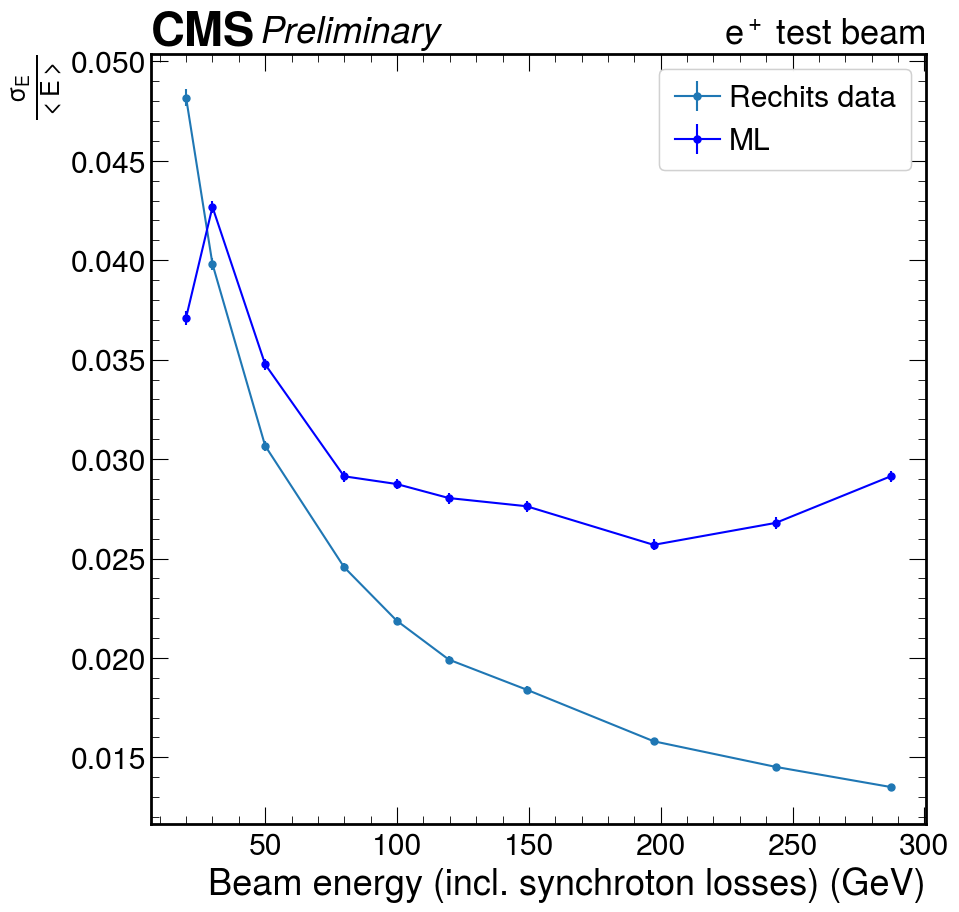

In [29]:
fig = plotter.plotSigmaOverE_debug()